In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
from persim import plot_diagrams
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from scipy.stats import ttest_rel
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

[*********************100%***********************]  9 of 9 completed


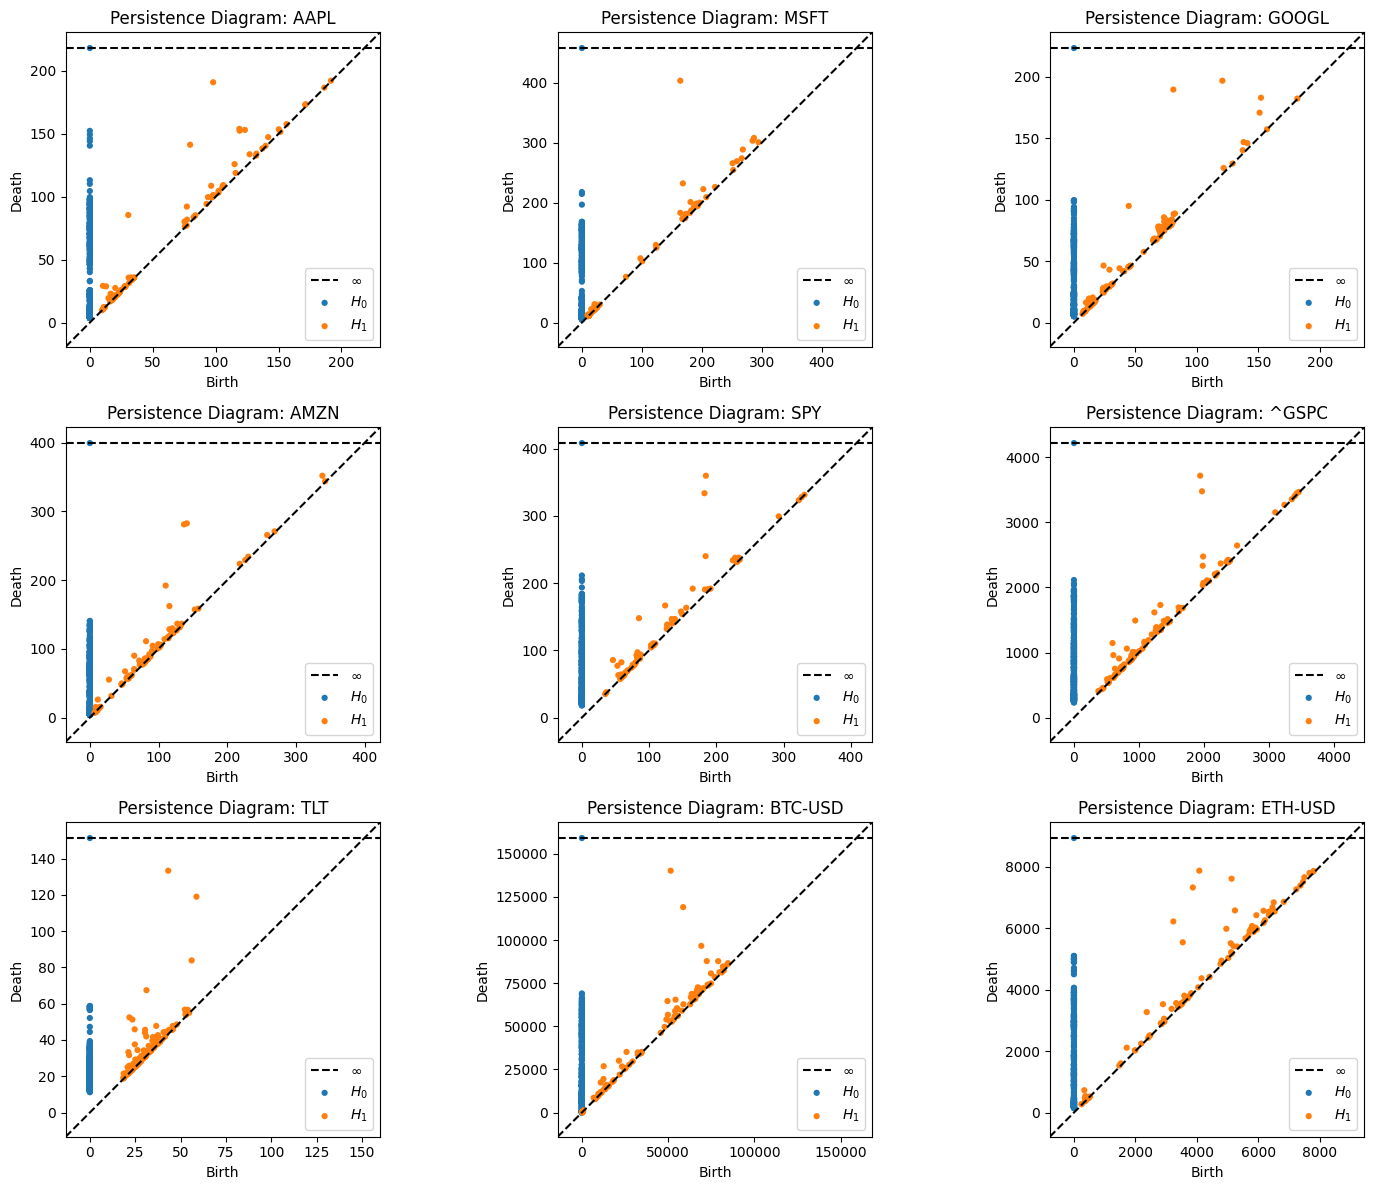

In [3]:
def fetch_adjusted_close(tickers, start_date, end_date):
    """
    Download daily adjusted close prices for a list of tickers.

    """
    raw = yf.download(tickers, start=start_date, end=end_date,
                      group_by='ticker', auto_adjust=True)
    adj_close = pd.DataFrame(index=raw.index)
    for ticker in tickers:
        try:
            series = raw[ticker]['Close']
        except (KeyError, TypeError):
            series = raw['Close'][ticker] if isinstance(raw['Close'], pd.DataFrame) else raw['Close']
        adj_close[ticker] = series
    return adj_close


def sliding_window(series, window_size, step_size):
    """
    Embed a 1D series into overlapping windows.

    """
    values = series.dropna().values
    n = len(values)
    indices = range(0, n - window_size + 1, step_size)
    return np.vstack([values[i : i + window_size] for i in indices])


def compute_persistence(embeddings, max_dimension=1):
    """
    Compute persistence diagrams for each embedded dataset.

    """
    diagrams = {}
    for label, data in embeddings.items():
        result = ripser(data, maxdim=max_dimension)
        diagrams[label] = result['dgms']
    return diagrams


def plot_all_diagrams(diagrams, columns=3):
    """
    Arrange and plot persistence diagrams in a grid.

    """
    labels = list(diagrams.keys())
    rows = int(np.ceil(len(labels) / columns))
    fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
    axes = axes.flatten()
    
    for ax, label in zip(axes, labels):
        plot_diagrams(diagrams[label], ax=ax, show=False)
        ax.set_title(f'Persistence Diagram: {label}')
    
    for ax in axes[len(labels):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    symbols = [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN',
        'SPY',  '^GSPC', 'TLT',
        'BTC-USD', 'ETH-USD'
    ]
    start = '2010-01-01'
    end = pd.Timestamp.today().strftime('%Y-%m-%d')
    prices = fetch_adjusted_close(symbols, start, end)
    window_size = 120
    step_size = 7
    embeddings = {
        sym: sliding_window(prices[sym], window_size, step_size)
        for sym in prices.columns
    }
    diagrams = compute_persistence(embeddings, max_dimension=1)
    plot_all_diagrams(diagrams, columns=3)